In [1]:
import tensorflow as tf

In [2]:
# adaptations for running Tensorflow on GeForce RTX 2080
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [38]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation, Add, Flatten, Conv2D, Dropout, LeakyReLU, Reshape

In [39]:
import PIL
from PIL import Image

In [40]:
# Loss function for the mixture of experts (based on SSIM)
def custom_ssim(y_actual, y_predicted):
    y_actual = (1+y_actual)/2
    y_predicted = (1+y_predicted)/2
    return 1 - tf.image.ssim(y_actual, y_predicted, max_val=1)

In [41]:
# Loading especialists
model1 = load_model('saved/residual_ssim_sigma3_(14, 2)/model.h5', custom_objects={'custom_ssim': custom_ssim})
model2 = load_model('saved/residual_ssim_sigma3_(2, 14)/model.h5', custom_objects={'custom_ssim': custom_ssim})

In [42]:
# Training and test parameters
num_train1 = 196 # number of images used in training degraded by sigma = 1 (gaussian blur)
num_train2 = 196 # number of images used in training degraded by sigma = 2 (gaussian blur)
num_test1 = 20 # number of images used in testing degraded by sigma = 1 (gaussian blur)
num_test2 = 20 # number of images used in testing degraded by sigma = 2 (gaussian blur)

In [43]:
# Loading data for training
soma1 = num_train1 + num_train2

xtrain1_aux = np.zeros((soma1, 256, 256, 1)) # array with degraded images for training
ytrain_aux = np.zeros((soma1, 256, 256, 1)) # array with non-degraded images for training

# Vertical degradation
# Images degraded by sigma = 3 and dimension = (14, 2) (gaussian blur)
for i in range (num_train1):
    xtrain1_aux[i, :, :, 0] = np.load('dataset196_gray/sigma3(14, 2)/arrays/' + str(i+1) + '.npy')
    ytrain_aux[i, :, :, 0] = np.load('dataset196_gray/original/arrays/' + str(i+1) + '.npy')

# Horizontal degradation
# Images degraded by sigma = 3 and dimension = (2, 14) (gaussian blur)
for i in range (num_train2):
    xtrain1_aux[i+num_train1, :, :, 0] = np.load('dataset196_gray/sigma3(2, 14)/arrays/' + str(i+1) + '.npy')
    ytrain_aux[i+num_train1, :, :, 0] = np.load('dataset196_gray/original/arrays/' + str(i+1) + '.npy')

In [44]:
# Normalizing data
xtrain1_aux = xtrain1_aux/(xtrain1_aux.max())
ytrain_aux = ytrain_aux/(ytrain_aux.max())

In [45]:
# Range of data: -1 to 1
xtrain1 = 2*xtrain1_aux - 1
ytrain = 2*ytrain_aux - 1

In [46]:
# Creating tensors for SSIM calculations
xtrain1_tf = tf.convert_to_tensor(xtrain1_aux)
ytrain_tf = tf.convert_to_tensor(ytrain_aux)

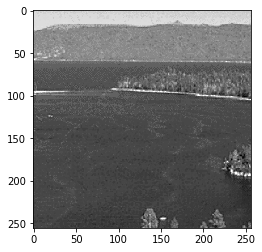

In [47]:
plt.imshow(ytrain_aux[56, :, :, 0], cmap='gray')

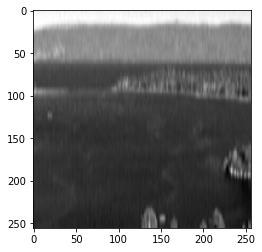

In [48]:
# Example of vertical degradation
plt.imshow(xtrain1_aux[56, :, :, 0], cmap='gray')

In [49]:
# Outputs from especialists
xtrain2_1 = model1.predict(xtrain1)
xtrain2_2 = model2.predict(xtrain1)
xtrain2 = np.concatenate((xtrain2_1, xtrain2_2), axis=-1)
xtrain2_aux = (1+xtrain2)/2 # array with the restoration of each especialists (also input for the mixture of especilaists)

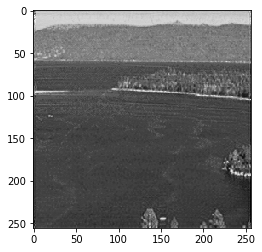

In [50]:
# Specialist for vertical degradation
plt.imshow(xtrain2[56, :, :, 0], cmap='gray')

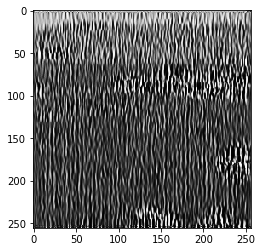

In [51]:
# Specialist for horizontal degradation
plt.imshow(xtrain2[56, :, :, 1], cmap='gray')

In [66]:
# Loading data for testing
soma1 = num_test1 + num_test2

xtest1_aux = np.zeros((soma1, 256, 256, 1)) # array with degraded images for testing
ytest_aux = np.zeros((soma1, 256, 256, 1)) # array with non-degraded images for training

# Vertical degradation
# Images degraded by sigma = 3 and dimension = (14, 2) (gaussian blur)
for i in range (num_test1):
    xtest1_aux[i, :, :, 0] = np.load('dataset20_gray/sigma3(14, 2)/arrays/degradada' + str(i+1) + '.npy')
    ytest_aux[i, :, :, 0] = np.load('dataset20_gray/original/arrays/original' + str(i+1) + '.npy')

# Horizontal degradation
# Images degraded by sigma = 3 and dimension = (2, 14) (gaussian blur)
for i in range (num_test2):
    xtest1_aux[i+num_test1, :, :, 0] = np.load('dataset20_gray/sigma3(2, 14)/arrays/degradada' + str(i+1) + '.npy')
    ytest_aux[i+num_test1, :, :, 0] = np.load('dataset20_gray/original/arrays/original' + str(i+1) + '.npy')

In [53]:
# Normalizing data
xtest1_aux = xtest1_aux/(xtest1_aux.max())
ytest_aux = ytest_aux/(ytest_aux.max())

In [54]:
# Range of data: -1 to 1
xtest1 = 2*xtest1_aux - 1
ytest = 2*ytest_aux - 1

In [55]:
# Creating tensors for SSIM calculations
xtest1_tf = tf.convert_to_tensor(xtest1_aux)
ytest_tf = tf.convert_to_tensor(ytest_aux)

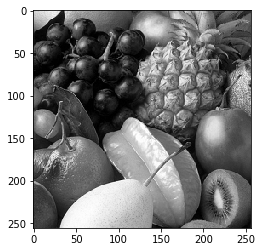

In [56]:
plt.imshow(ytest_aux[24, :, :, 0], cmap='gray')

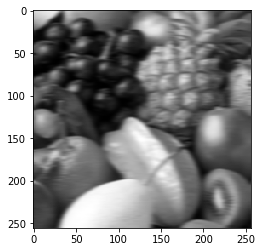

In [57]:
# Example of horizontal degradation
plt.imshow(xtest1_aux[24, :, :, 0], cmap='gray')

In [58]:
# Outputs from specialists
xtest2_1 = model1.predict(xtest1)
xtest2_2 = model2.predict(xtest1)
xtest2 = np.concatenate((xtest2_1, xtest2_2), axis=-1)
xtest2_aux = (1+xtest2)/2 # array with the restoration of each especialists (also input for the mixture of especilaists)

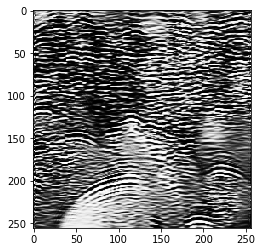

In [59]:
# Specialist for vertical degradation
plt.imshow(xtest2[24, :, :, 0], cmap='gray')

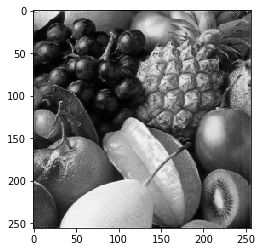

In [60]:
# Specialist for horizontal degradation
plt.imshow(xtest2[24, :, :, 1], cmap='gray')

In [61]:
# Mixture of specialists model
def make_model(input_shape1, input_shape2):
  
    X1_input = Input(input_shape1)
    X2_input = Input(input_shape2)
    
    X = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(X1_input)
    X = LeakyReLU()(X)
    X = Dropout(0.3)(X)

    X = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(X)
    X = LeakyReLU()(X)
    X = Dropout(0.3)(X)
    
    X = Flatten()(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    
    X = Reshape((1, 1, 2))(X)
    Y = tf.math.multiply(X, X2_input)
    Y = tf.math.reduce_sum(Y, axis=-1, keepdims=True)

    model = Model(inputs=[X1_input, X2_input] , outputs=Y, name='model')
    
    return model

In [62]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [63]:
opt = Adam(lr=1e-5)

In [64]:
# Training with 2 GPUs
with mirrored_strategy.scope():
    model = make_model(xtrain1.shape[1:], xtrain2.shape[1:])
    model.compile(optimizer=opt, loss=custom_ssim)

In [65]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 64) 1664        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_2 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 128, 128, 64) 0           leaky_re_lu_2[0][0]              
______________________________________________________________________________________________

In [33]:
history = model.fit(x=[xtrain1, xtrain2], y=ytrain, epochs=10000, validation_data=[[xtest1, xtest2], ytest], batch_size=20)

Train on 392 samples, validate on 40 samples
Epoch 1/10000
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
380/392 [============================>.] - ETA: 0s - loss: 0.6837INFO:tensorflo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1589
Epoch 3488/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1589
Epoch 3489/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1587
Epoch 3490/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1588
Epoch 3491/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1589
Epoch 3492/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1585
Epoch 3493/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1586
Epoch 3494/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1584
Epoch 3495/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1585
Epoch 3496/10000
392/392 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1571
Epoch 3921/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1561
Epoch 3922/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1536
Epoch 3923/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1553
Epoch 3924/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1567
Epoch 3925/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1554
Epoch 3926/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1560
Epoch 3927/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1560
Epoch 3928/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1570
Epoch 3929/10000
392/392 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 6640/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1709
Epoch 6641/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1709
Epoch 6642/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1712
Epoch 6643/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1712
Epoch 6644/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1714
Epoch 6645/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1714
Epoch 6646/10000
392/392 [==============================] - 1s 3ms/sample - loss: 0.0661 - val_loss: 0.1712
Epoch 6647/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1712
Epoch 6648/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1711
Epoch 6649/10000
392/392 [==

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1734
Epoch 7969/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1733
Epoch 7970/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1730
Epoch 7971/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1729
Epoch 7972/10000
392/392 [==============================] - 1s 3ms/sample - loss: 0.0661 - val_loss: 0.1732
Epoch 7973/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1734
Epoch 7974/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1737
Epoch 7975/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1737
Epoch 7976/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1736
Epoch 7977/10000
392/392 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1769
Epoch 9304/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1770
Epoch 9305/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1769
Epoch 9306/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1771
Epoch 9307/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1769
Epoch 9308/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1768
Epoch 9309/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1767
Epoch 9310/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1767
Epoch 9311/10000
392/392 [==============================] - 1s 2ms/sample - loss: 0.0661 - val_loss: 0.1770
Epoch 9312/10000
392/392 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dict_keys(['loss', 'val_loss'])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


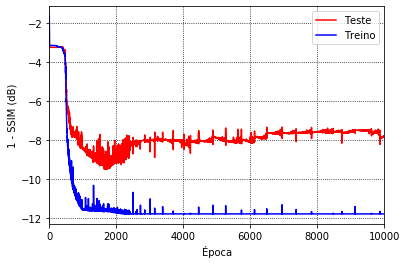

In [34]:
# Plotting loss
plt.plot(10*np.log10(history.history['val_loss']), 'r', label='Teste')
plt.plot(10*np.log10(history.history['loss']), 'b', label='Treino')
plt.legend(loc='upper right')
plt.xlim(0, 10000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('1 - SSIM (dB)')
plt.xlabel('Época')
plt.savefig('saved/moe_sigma3_(14, 2)(2, 14)/error.eps', format='eps')
plt.show()

In [38]:
# Saving model
model.save('saved/moe_sigma3_(14, 2)(2, 14)/model.h5')